In [1]:
!pip install serial -q
!pip install catboost -q
!pip install hyperopt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 787.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler

import statsmodels.graphics.tsaplots as sgt
import scipy.stats as stats

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from functools import partial
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

%matplotlib inline
sns.set_context("talk")

# random state
RS = 1
# %matplotlib widget

In [3]:
#В колабе импортируем все необходимые библиотеки
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "1NawWHBHXznAtBE_t-XRxM4p986eYmrZU"})
# https://drive.google.com/file/d/1NawWHBHXznAtBE_t-XRxM4p986eYmrZU/view?usp=drive_link
download.GetContentFile("2023-05-31_17-14-41.palm")

download = drive.CreateFile({"id": "1g1pd5vZfFKYEXoX47FQ0XWjnh3IRIBPQ"})
# https://drive.google.com/file/d/1g1pd5vZfFKYEXoX47FQ0XWjnh3IRIBPQ/view?usp=sharing
download.GetContentFile("2023-05-31_17-14-41.palm.protocol.csv")

download = drive.CreateFile({"id": "1sVN7vFqUow4hQkt0Ef0GKGA4EhxlOQJZ"})
# https://drive.google.com/file/d/1sVN7vFqUow4hQkt0Ef0GKGA4EhxlOQJZ/view?usp=drive_link
download.GetContentFile("meta_information.csv")

download = drive.CreateFile({"id": "1i27QLfHXESzeFf1yz7RLkReq0meTfv8x"})
# https://drive.google.com/file/d/1i27QLfHXESzeFf1yz7RLkReq0meTfv8x/view?usp=sharing
download.GetContentFile("2023-05-31_15-46-37.palm.protocol.csv")

download = drive.CreateFile({"id": "1r4wVpeHrHYMdAV00hU_DrETAYDJZukhv"})
# https://drive.google.com/file/d/1r4wVpeHrHYMdAV00hU_DrETAYDJZukhv/view?usp=sharing
download.GetContentFile("2023-05-31_15-46-37.palm")

In [4]:
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical

# IO utils


In [5]:
def read_omg_csv(path_palm_data: str,
                 n_omg_channels: int,
                 n_acc_channels: int = 0,
                 n_gyr_channels: int = 0,
                 n_mag_channels: int = 0,
                 n_enc_channels: int = 0,
                 button_ch: bool = True,
                 sync_ch: bool = True,
                 timestamp_ch: bool = True) -> pd.DataFrame:

    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''

    df_raw = pd.read_csv(path_palm_data, sep=' ',
                         header=None,
                         skipfooter=1,
                         skiprows=1,
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()

    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'],
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]

    if button_ch:
        columns = columns + ['BUTTON']

    if sync_ch:
        columns = columns + ['SYNC']

    if timestamp_ch:
        columns = columns + ['ts']

    df_raw.columns = columns

    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [6]:
palm_file = '/content/2023-05-31_15-46-37.palm'
gestures = read_omg_csv(palm_file,
                              n_omg_channels=50,
                              n_acc_channels=3,
                              n_gyr_channels=3,
                              n_enc_channels=6,
                              n_mag_channels=0)

print(gestures.shape)
gestures.head()

(19566, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,9,6,8,8,8,0,10,8,11,8,...,0,0,0,0,0,0,0,0,0,57807
1,6,6,6,6,8,0,8,7,8,8,...,-1,0,0,0,0,0,0,0,0,57840
2,10,4,7,6,6,2,7,10,11,9,...,0,0,0,0,0,0,0,0,0,57873
3,10,8,5,10,6,4,6,8,10,11,...,-1,0,0,0,0,0,0,0,0,57906
4,9,8,8,17,8,0,6,8,11,7,...,-2,0,0,0,0,0,0,0,0,57939


In [7]:
gestures['SYNC'].max()

180

In [8]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [9]:
gestures.shape[-1]

65

In [10]:
gestures.shape

(19566, 65)

In [11]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

#gestures[OMG_CH + ACC_CH + GYR_CH + ENC_CH]

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


### Protocol

In [12]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
gestures_protocol.head(10)

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [13]:
gestures_protocol['Pronation'].value_counts()

0.0    61
0.5    60
1.0    60
Name: Pronation, dtype: int64

In [14]:
gestures_protocol.shape

(181, 11)

In [15]:
le = LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [16]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [17]:
gestures_protocol['gesture']

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 181, dtype: int64

In [18]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

## Определение временной задержки целевой переменной.

### Визуализация имеющегося сдвига

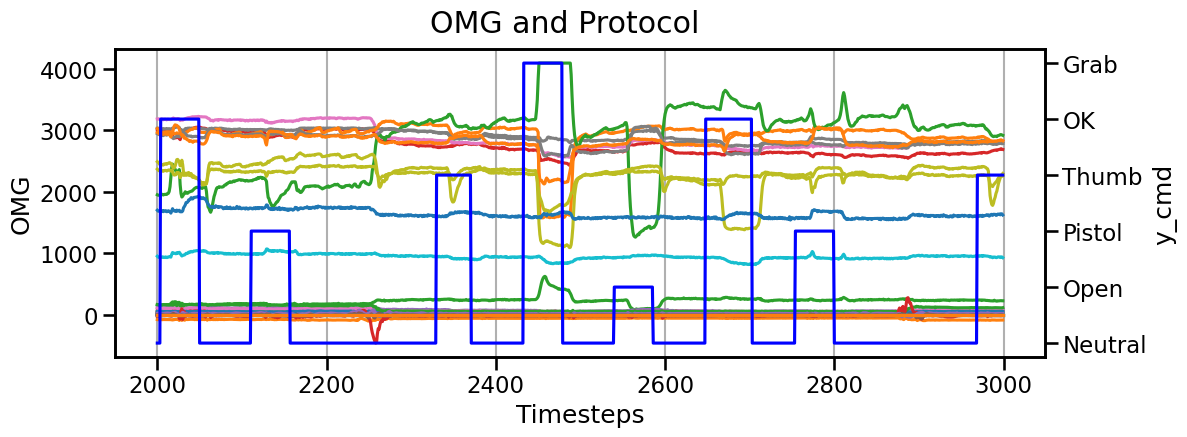

In [19]:
fig, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
plt.suptitle('OMG and Protocol')
ax1.plot(gestures[OMG_CH + ACC_CH + GYR_CH + ENC_CH][2000:3000])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('OMG')
plt.grid(axis='x')
ax2 = ax1.twinx()
target_df = pd.DataFrame(y_cmd)
ax2.plot(target_df[2000:3000], 'b-')
ax2.set_ylabel('y_cmd')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.show()

In [20]:
def add_feature_derivative(df):
  """Функция для добавления признака производной

    Args:
        df (DataFrame): датасет

    Returns:
        df_log(DataFrame): датасет с добавленным признаком производной
  """
  col_list_base = list(df.columns) #исходный список признаков
  df_temp = df.copy()
  for i in col_list_base:
    col_add = f'der_{i}' #название для нового признака
    df_temp[col_add] = df_temp[i].diff() #создаем признак
    df_temp.fillna(0, inplace = True) #удаляем пустоты
  df_temp.drop(col_list_base, axis = 1 , inplace = True)
  return df_temp

def get_clean_lines(df, treshold = 1.5):
  """Функция для преобразования временного ряда.
  Преобразует все значения выше определенного порога в 1, ниже в 0

    Args:
        df (Series): датасет

    Returns:
        result(DataFrame): преобразованный датасет
  """
  result = np.zeros(df.shape) #создаем массив заполненный нулями размером с датасет
  means = np.mean(df) #выводим среднюю
  for i in range(df.shape[0]): #перебираем значения
    if abs(df[i]) > means*treshold:  #реализуем логику
      result[i] = 1
    else:
      result[i] = 0
  return pd.DataFrame(result)

def shift_definition(df, target):
  """Функция для нахождения временной задержки между командой и её исполнением

    Args:
        df (DataFrame): датасет с показаниями датчиков
        target (DataFrame): данные протокола выполнения команд
    Returns:
        best_shift (int): временной сдвиг
  """
  # рассчитываем производные значений временных датчиков
  gestures_der = add_feature_derivative(df)
  # суммируем модули значений производных
  gestures_der_sum = abs(gestures_der).sum(axis = 1)
  # обнуляем значения ниже порога
  gestures_der_sum_clean = get_clean_lines(gestures_der_sum, treshold = 1.5)

  # преобразуем целевую переменную в DataFrame
  target_df = pd.DataFrame(target)
  # рассчитываем производные значений таргета
  target_der = add_feature_derivative(target_df)
  # преобразуем таргет, если есть жест 1, если нет 0
  for i in range(len(target_der)):
      if (target_der.iloc[i] != 0).bool():
        target_der.iloc[i] = 1

  # объединяем преобразованный таргет и преобрразованную сумму производных в одну таблицу
  data = pd.concat([gestures_der_sum_clean.shift(1), target_der], axis=1).dropna()
  data.columns = ['y_t', 'first_derivative']
  # определяем, при каком сдвиге корреляция  максимальна
  corr_temp = []
  for i in range(1, 40):
    data['y_t'] = data['y_t'].shift(i)
    corr_coef = data.corr()
    corr_temp.append(corr_coef.iloc[1,0])
  l = pd.Series(corr_temp)
  best_shift = l[l == max(corr_temp)]
  return best_shift.index[0]

In [21]:
best_shift = shift_definition(gestures[OMG_CH + ACC_CH + GYR_CH + ENC_CH], y_cmd)
print(best_shift)

23


### Визуализация соответствия команд и показаний от датчиков после сдвига целевой переменной

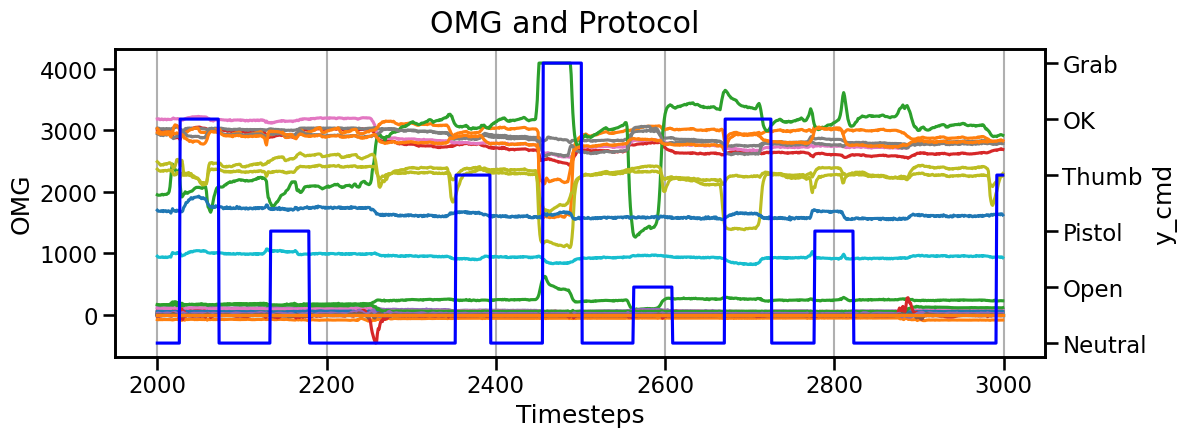

In [22]:
fig, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
plt.suptitle('OMG and Protocol')
ax1.plot(gestures[OMG_CH + ACC_CH + GYR_CH + ENC_CH][2000:3000])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('OMG')
plt.grid(axis='x')
ax2 = ax1.twinx()
target_df = pd.DataFrame(y_cmd)
ax2.plot(target_df.shift(best_shift)[2000:3000], 'b-')
ax2.set_ylabel('y_cmd')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.show()

In [23]:
# сдвигаем значения таргета
target_df = target_df.shift(best_shift).fillna(0)
y_cmd_shift = target_df.to_numpy()
y_cmd_shift

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

## Предобработка данных

## Удаление столбцов с нулевым значением

In [24]:
def reset_zero_features(df):
  """Функция для удаления признаков с нулевым значением

    Args:
        df (DataFrame): датасет

    Returns:
        df (DataFrame): датасет с удалёнными признаками с нулевым значением
  """
  df_temp = df.copy()
  df_sum = df_temp.apply(lambda x: x.sum()) #находим сумму по столбцам
  df_zero = df_sum[df_sum == 0] # фильтруем по нулевому значению
  zero_index = list(df_zero.index) # список названий признаков с нулевым значением
  df_temp.drop (zero_index, axis= 1 , inplace= True ) #удаление из датасета признаков с нулевым значением
  return df_temp

In [25]:
gestures = reset_zero_features(gestures[OMG_CH + ACC_CH + GYR_CH + ENC_CH])
gestures.shape

(19566, 56)

## Пороговый фильтр

Убираем шумовые признаки, которые просто колеблятся с некоторой маленькой амплитудой, которая не изменяется при изменении команды жеста.

In [26]:
# объединим наблюдения и целевую переменную, скорректированную на величину временной задержки между командой и действием
# data_united = gestures[OMG_CH + ACC_CH + GYR_CH].join(target_df)
data_united = gestures.join(target_df)
data_united.rename(columns = {0:'GEST'}, inplace = True)
data_united['GEST'] = data_united['GEST'].astype(int)
data_united_col = data_united.columns


In [27]:
# подготовим данные для определения пороговых величин
data_c = RobustScaler().fit_transform(data_united)
data_c = StandardScaler().fit_transform(data_c)
data_c = pd.DataFrame(data_c, columns = data_united_col)

In [28]:
def test_shapiro(data, alpha = 0.05):
  # проводим тест Шапиро — Уилка
  _, p = stats.shapiro(data)
  # интерпретируем результат
  if p <= alpha:
      return 1 #'Распределение не нормальное'
  else:
      return 0 # 'Распределение нормальное'

In [29]:
def feature_threshold_filter(data, alpha = 0.05):
  """Функция для определения признаков, изменение которых при разных жестах статистически незначимо.

    Args:
        data (DataFrame): датасет
        alpha (int): уровень значимости. Default = 0.05
    Returns:
        bad_list (list): список датчиков, изменение которых в зависимости от жеста статистически незначимо.
        good_list (list): список датчиков, изменение которых в зависимости от жеста статистически значимо.
  """
  bad_list = [] #список статистически незначимых признаков
  good_list = [] #список статистически значимых признаков
  data_columns = list(data.columns) #список признаков
  data_columns.remove('GEST')

  for col in data_columns: # для каждого признака готовим данные для теста, состоящие из серии показаний датчиков при показе жестов
    data_vc = data[[col,'GEST']]['GEST'].value_counts()
    min_count = data_vc.min() # находим минимальное значение наблюдений для каждого жеста, т.к.
  # для проведения теста необходимо одинаковое количество наблюдений в выборках

    data_temp = data_united[[col,'GEST']]
    data_for_test = pd.DataFrame()
    data_0 = data_temp[data_temp['GEST'] == 0][col]
    data_for_test['0'] = np.array(data_0[:min_count])
    data_1 = data_temp[data_temp['GEST'] == 1][col]
    data_for_test['1'] = np.array(data_1[:min_count])
    data_2 = data_temp[data_temp['GEST'] == 2][col]
    data_for_test['2'] = np.array(data_2[:min_count])
    data_3 = data_temp[data_temp['GEST'] == 3][col]
    data_for_test['3'] = np.array(data_3[:min_count])
    data_4 = data_temp[data_temp['GEST'] == 4][col]
    data_for_test['4'] = np.array(data_4[:min_count])
    data_5 = data_temp[data_temp['GEST'] == 5][col]
    data_for_test['5'] = np.array(data_5[:min_count])

    # для каждой серии наблюдений определяем нормальность распределения признака
    data_for_test_col = data_for_test.columns
    count_distr = 0
    # в случае если признак распределен ненормально, функция test_shapiro возвращает 1,
    # т.о. суммируя возвраты функции от каждого признака можно определить, какой тест использовать для определения статистической значимости
    for i in data_for_test_col:
      res_test = test_shapiro(data_for_test[i])
      count_distr += res_test
    # print(count_distr)

    if count_distr == 0: #распределение признаков нормальное
      # Применяем КРИТЕРИЙ КРАСКЕЛА — УОЛЛИСА
      # Нулевая гипотеза: распределения изменений сигнала от датчиков одинаковы
      # Альтернативная гипотеза: распределения изменений сигнала от датчиков не одинаковы
      _, p = stats.kruskal(data_for_test['0'], data_for_test['1'], data_for_test['2'], data_for_test['3'], data_for_test['4'], data_for_test['5'])
      # интерпретируем результат
      if p <= alpha:
        # p-значение меньше, чем заданный уровень значимости. Отвергаем нулевую гипотезу
        bad_list.append(col)
      else:
        # p-значение больше, чем заданный уровень значимости. У нас нет оснований отвергнуть нулевую гипотезу.
        good_list.append(input)
    else: #распределение признаков ненормальное
          # применяем КРИТЕРИЙ ФРИДМАНА
          # Нулевая гипотеза: распределения изменений сигнала от датчиков одинаковы
         # Альтернативная гипотеза: распределения изменений сигнала от датчиков не одинаковы
      _, p = stats.friedmanchisquare(data_for_test['0'], data_for_test['1'], data_for_test['2'], data_for_test['3'], data_for_test['4'], data_for_test['5'])
      # интерпретируем результат
      if p <= alpha:
        # p-значение меньше, чем заданный уровень значимости. Отвергаем нулевую гипотезу
        bad_list.append(col)
      else:
        # p-значение больше, чем заданный уровень значимости. У нас нет оснований отвергнуть нулевую гипотезу.
        good_list.append(col)
  return bad_list, good_list

In [30]:
bad_list, good_list = feature_threshold_filter(data_c,  alpha = 0.05)

In [31]:
print(bad_list)

['2', '4', '8', '11', '12', '13', '14', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '46', '47', '48', '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2']


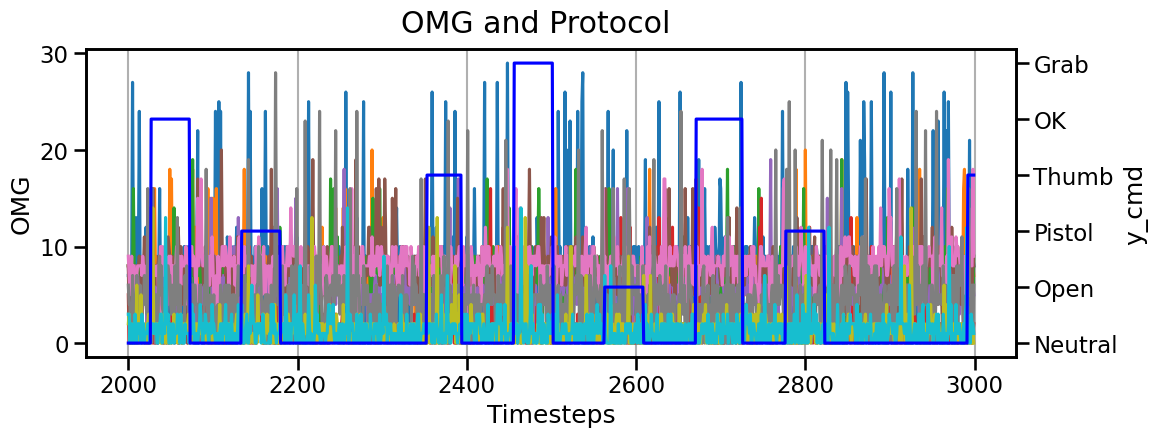

In [32]:
fig, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
plt.suptitle('OMG and Protocol')
ax1.plot(gestures[good_list][2000:3000])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('OMG')
plt.grid(axis='x')
ax2 = ax1.twinx()
target_df = pd.DataFrame(y_cmd)
ax2.plot(target_df.shift(best_shift)[2000:3000], 'b-')
ax2.set_ylabel('y_cmd')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.show()

In [33]:
gestures = gestures[good_list]
gestures.shape

(19566, 10)

## Добавление признака с экспоненциально взвешенными скользящими средними

In [34]:
def add_ewm_feature(df, span=10):
    """
    Функция для добавления столбцов с экспоненциально взвешенными скользящими
    средними (ewm) для каждого признака в DataFrame.

    Args:
        df (DataFrame): Исходный DataFrame
        span (int): Параметр span для расчета ewm (по умолчанию 10)
    Returns:
        DataFrame: DataFrame с добавленными столбцами 'ewm' для каждого признака
    """
    df_temp = df.copy()
    df_col = list(df_temp.columns)
    for col in df_col:
        df_temp[f'{col}_ewm'] = df_temp[col].ewm(span=span, adjust=False).mean()
    df_temp.drop(df_col, axis = 1, inplace = True)

    return df_temp

In [35]:
gestures = add_ewm_feature(gestures)
col_ewm = list(gestures.columns)

## Добавление суммы изменений признака за последние несколько временных шагов.

In [36]:
def add_weight_sum(df, size = 5, win_type = 'triang'):
  """Фунуция для добавления признака скользящей суммы, c весами значений

    Args:
        df (DataFrame): выборка
        col_for_roll(str): список признаков из общей выборки для обработки
        size(int): размер окна
        metod(str): веса. Действительная оконная функция scipy.signal

    Returns:
        df_log(DataFrame): датасет с добавленным признаком скользящей суммы, c весами значений
  """
  df_temp = df.copy()
  col_for_roll = df_temp.columns
  for i in col_for_roll:
    col_add = f'add_{size}_{i}' #название для нового признака
    df_temp[col_add] = round(df_temp[i].rolling(window = size, win_type = win_type).sum()) #создаем признак
    df_temp.fillna(0, inplace = True) #удаляем нули

  return df_temp

gestures = add_weight_sum(gestures, size = 5, win_type = 'triang')

gestures.head(10)

,0_ewm,1_ewm,3_ewm,5_ewm,6_ewm,7_ewm,9_ewm,10_ewm,15_ewm,45_ewm,add_5_0_ewm,add_5_1_ewm,add_5_3_ewm,add_5_5_ewm,add_5_6_ewm,add_5_7_ewm,add_5_9_ewm,add_5_10_ewm,add_5_15_ewm,add_5_45_ewm
0,9.000000,6.000000,8.000000,0.000000,10.000000,8.000000,8.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.454545,6.000000,7.636364,0.000000,9.636364,7.818182,8.000000,0.000000,0.818182,0.545455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.735537,5.636364,7.338843,0.363636,9.157025,8.214876,8.181818,0.909091,1.396694,0.628099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.965440,6.066116,7.822690,1.024793,8.583020,8.175808,8.694215,1.834711,2.051841,0.695718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.971723,6.417731,9.491292,0.838467,8.113380,8.143843,8.386176,1.501127,1.678779,0.932860,26.0,18.0,23.0,1.0,27.0,24.0,25.0,3.0,4.0,2.0
5,8.613228,6.523598,9.220148,0.686019,7.547311,7.572235,8.315962,1.955468,1.373546,0.763249,26.0,18.0,25.0,2.0,26.0,24.0,25.0,4.0,5.0,2.0
6,8.319914,6.792035,8.998303,0.743106,7.084164,7.650010,8.440333,1.599928,1.851083,0.806295,26.0,19.0,26.0,2.0,24.0,24.0,25.0,5.0,5.0,2.0
7,7.898111,5.557119,9.180429,0.971632,6.887043,7.350008,7.996636,2.218123,1.514523,1.023332,26.0,19.0,27.0,2.0,23.0,23.0,25.0,5.0,5.0,2.0
8,7.553000,5.274007,8.965806,0.976790,6.907581,7.286371,7.997247,2.542101,1.239155,1.019090,25.0,19.0,27.0,2.0,22.0,23.0,25.0,6.0,5.0,3.0
9,7.816091,5.406006,9.153841,0.799192,6.924384,8.325212,7.634112,2.988991,1.013854,0.833801,24.0,18.0,27.0,3.0,21.0,23.0,24.0,7.0,4.0,3.0


## Определение максимального количества лагов

In [37]:
def plot_acf_pacf(series, lags, alpha=0.05):
    """Функция для построения графиков автокорреляции и частичной корреляции(коррелограм)

    Args:
        series (DataFrame, array): стационарный временной ряд
        lags (_type_): количество предыдущих наблюдений для поиска схожести/зависимости
        alpha (float, optional): Доверительный интервал. Defaults to 0.05.
    """

    plt.rcParams["figure.figsize"] = 18, 5 #размеры графика
    fig, axes = plt.subplots(1, 2)
    sgt.plot_acf(series, ax=axes[0], lags=lags, alpha=alpha)#построение графика автокорреляции
    sgt.plot_pacf(series, ax=axes[1], lags=lags, method="ywm", alpha=alpha)#построение графика автокорреляции
    plt.show()

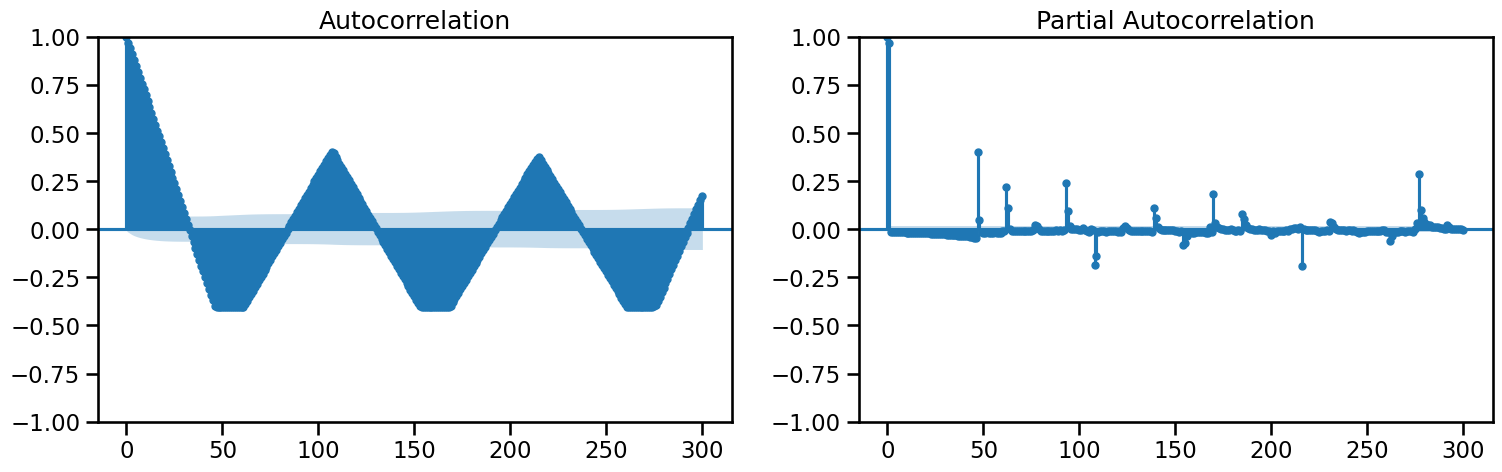

In [38]:
plot_acf_pacf(y_cmd, 300)

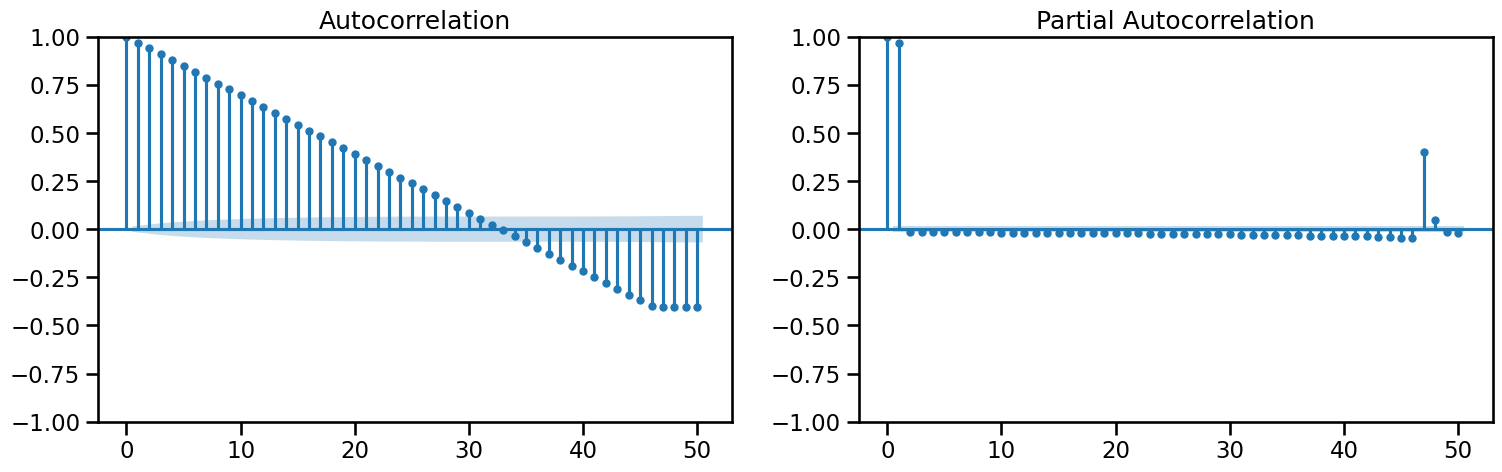

In [39]:
plot_acf_pacf(y_cmd, 50)

Вывод: использовать сдвиг более чем на 46 лагов не имеет смысла, т.к. модель будет обманывать сама себя

## Добавление лагов

In [40]:
def add_lag(df, col_list, step, lag_n):
  """Функция для добавления временных лагов в выборку с шагом

    Args:
        df (DataFrame): выборка
        lag_n(int): количество временных лагов
        col_list(list): список признаков из общей выборки для обработки
        step(int): шаг сдвига по признакам

    Returns:
        df_log(DataFrame): датасет с добавленными временными лагами, пропуски заполнены 0
        col_list(list): список признаков с их временными лагами
  """
  df_log = df[col_list].copy() #coздаем новый датасет для добавления новых признаков
  col_list_base = list(df_log.columns) #исходный список признаков
  col_step = [] #список признаков с шагом
  for i in range(0, len(col_list), step): #перебираем признаки
    col_step.append(col_list[i]) #формируем список признаков с шагом
  for _, col in enumerate(col_step): #перебираем список признаков с шагом
    for n, v in enumerate(range(1,lag_n)): #перебираем лаги
      col_lag = f'lag_{col}_{v}' #название для нового признака
      df_log[col_lag] = df_log.loc[:, col].shift(v, fill_value = 0) #создаем новый признак
      col_list_base.append(col_lag)

  return df_log, col_list

In [41]:
# list_log = OMG_CH #список признаков из общей выборки для обработки
# list_log = list(gestures.columns)
gestures_log, OMG_CH_LAG = add_lag(gestures, col_ewm, 3, 7) #выполняем функцию сдвига признаков с лагом
gestures_log.drop(col_ewm, axis= 1, inplace= True ) #удаляем дублированнные признаки
gestures = pd.concat([gestures, gestures_log], axis=1) #соединяем изначальную таблицу и таблицу новых признаков
gestures.head(10)

,0_ewm,1_ewm,3_ewm,5_ewm,6_ewm,7_ewm,9_ewm,10_ewm,15_ewm,45_ewm,...,lag_9_ewm_3,lag_9_ewm_4,lag_9_ewm_5,lag_9_ewm_6,lag_45_ewm_1,lag_45_ewm_2,lag_45_ewm_3,lag_45_ewm_4,lag_45_ewm_5,lag_45_ewm_6
0,9.000000,6.000000,8.000000,0.000000,10.000000,8.000000,8.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,8.454545,6.000000,7.636364,0.000000,9.636364,7.818182,8.000000,0.000000,0.818182,0.545455,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,8.735537,5.636364,7.338843,0.363636,9.157025,8.214876,8.181818,0.909091,1.396694,0.628099,...,0.000000,0.000000,0.000000,0.000000,0.545455,0.000000,0.000000,0.000000,0.000000,0.000000
3,8.965440,6.066116,7.822690,1.024793,8.583020,8.175808,8.694215,1.834711,2.051841,0.695718,...,8.000000,0.000000,0.000000,0.000000,0.628099,0.545455,0.000000,0.000000,0.000000,0.000000
4,8.971723,6.417731,9.491292,0.838467,8.113380,8.143843,8.386176,1.501127,1.678779,0.932860,...,8.000000,8.000000,0.000000,0.000000,0.695718,0.628099,0.545455,0.000000,0.000000,0.000000
5,8.613228,6.523598,9.220148,0.686019,7.547311,7.572235,8.315962,1.955468,1.373546,0.763249,...,8.181818,8.000000,8.000000,0.000000,0.932860,0.695718,0.628099,0.545455,0.000000,0.000000
6,8.319914,6.792035,8.998303,0.743106,7.084164,7.650010,8.440333,1.599928,1.851083,0.806295,...,8.694215,8.181818,8.000000,8.000000,0.763249,0.932860,0.695718,0.628099,0.545455,0.000000
7,7.898111,5.557119,9.180429,0.971632,6.887043,7.350008,7.996636,2.218123,1.514523,1.023332,...,8.386176,8.694215,8.181818,8.000000,0.806295,0.763249,0.932860,0.695718,0.628099,0.545455
8,7.553000,5.274007,8.965806,0.976790,6.907581,7.286371,7.997247,2.542101,1.239155,1.019090,...,8.315962,8.386176,8.694215,8.181818,1.023332,0.806295,0.763249,0.932860,0.695718,0.628099
9,7.816091,5.406006,9.153841,0.799192,6.924384,8.325212,7.634112,2.988991,1.013854,0.833801,...,8.440333,8.315962,8.386176,8.694215,1.019090,1.023332,0.806295,0.763249,0.932860,0.695718


## Корреляционный анализ

In [42]:
def high_correlation_lower_triangle(data, threshold=0.85):
    corr_matrix = pd.DataFrame(data).corr().abs()
    mask = np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool)
    lower_triangle_corr = corr_matrix.where(mask)

    high_corr = (lower_triangle_corr > threshold) & (lower_triangle_corr < 1.0)
    correlated_vars = []

    for column in high_corr.columns:
        correlated = list(high_corr.index[high_corr[column]])
        for var in correlated:
            if high_corr.loc[var, column]:
                correlated_vars.append((column, var))
    correlated_vars = set([x for t in correlated_vars for x in t])
    return correlated_vars

lst = high_correlation_lower_triangle(gestures)
print(lst)

{'lag_0_ewm_3', 'lag_9_ewm_5', 'lag_5_ewm_2', 'lag_5_ewm_1', 'lag_0_ewm_1', 'lag_9_ewm_1', 'lag_9_ewm_6', 'lag_0_ewm_2', 'add_5_9_ewm', 'lag_5_ewm_3', 'lag_9_ewm_2', 'lag_45_ewm_1', 'lag_9_ewm_3', 'add_5_5_ewm', 'lag_45_ewm_3', 'add_5_0_ewm', 'lag_45_ewm_2', 'add_5_45_ewm'}


In [43]:
# Определим корреляцию с целевым признаком
# объединим наблюдения и целевую переменную, скорректированную на величину временной задержки между командой и действием

data_united = gestures.join(target_df)
data_united.rename(columns = {0:'GEST'}, inplace = True)
data_united['GEST'] = data_united['GEST'].astype(int)
data_united_col = data_united.columns

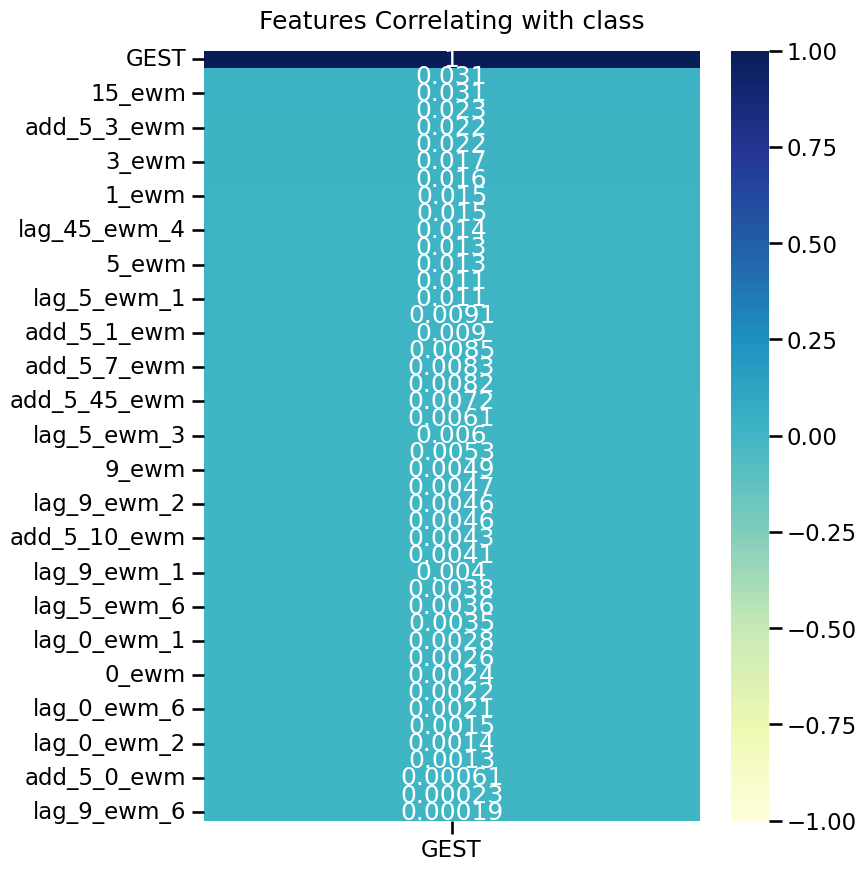

In [44]:
# определим корреляцию признаков с целевым признаком
plt.figure(figsize=(8, 10))
data_corr = abs(data_united.corr())
heatmap = sns.heatmap(data_corr[['GEST']].sort_values(by= 'GEST', ascending=False), vmin=-1, vmax=1, annot=True, cmap="YlGnBu")
heatmap.set_title('Features Correlating with class', fontdict={'fontsize':18}, pad=16);
# stop_drop = data_corr[len(data_corr):]


In [45]:
stop_list_corr = set(data_corr[['GEST']].sort_values(by= 'GEST', ascending=False)[:len(data_corr)//2].index)
print(stop_list_corr)

{'GEST', 'lag_45_ewm_5', '3_ewm', 'add_5_3_ewm', '5_ewm', 'lag_45_ewm_2', 'add_5_6_ewm', 'lag_45_ewm_6', '15_ewm', '7_ewm', 'lag_5_ewm_1', 'lag_5_ewm_2', 'lag_45_ewm_4', '6_ewm', 'add_5_1_ewm', 'add_5_15_ewm', 'lag_45_ewm_3', 'add_5_45_ewm', 'lag_45_ewm_1', '1_ewm', 'add_5_7_ewm', 'add_5_5_ewm'}


In [46]:
stop_list_corr

{'15_ewm',
 '1_ewm',
 '3_ewm',
 '5_ewm',
 '6_ewm',
 '7_ewm',
 'GEST',
 'add_5_15_ewm',
 'add_5_1_ewm',
 'add_5_3_ewm',
 'add_5_45_ewm',
 'add_5_5_ewm',
 'add_5_6_ewm',
 'add_5_7_ewm',
 'lag_45_ewm_1',
 'lag_45_ewm_2',
 'lag_45_ewm_3',
 'lag_45_ewm_4',
 'lag_45_ewm_5',
 'lag_45_ewm_6',
 'lag_5_ewm_1',
 'lag_5_ewm_2'}

Выберем и удалим высокоскореллированные признаки.

In [47]:
drop_corr_feat = lst - stop_list_corr

In [48]:
gestures.drop(drop_corr_feat, axis = 1, inplace = True)
gestures

,0_ewm,1_ewm,3_ewm,5_ewm,6_ewm,7_ewm,9_ewm,10_ewm,15_ewm,45_ewm,...,lag_5_ewm_4,lag_5_ewm_5,lag_5_ewm_6,lag_9_ewm_4,lag_45_ewm_1,lag_45_ewm_2,lag_45_ewm_3,lag_45_ewm_4,lag_45_ewm_5,lag_45_ewm_6
0,9.000000,6.000000,8.000000,0.000000,10.000000,8.000000,8.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,8.454545,6.000000,7.636364,0.000000,9.636364,7.818182,8.000000,0.000000,0.818182,0.545455,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,8.735537,5.636364,7.338843,0.363636,9.157025,8.214876,8.181818,0.909091,1.396694,0.628099,...,0.000000,0.000000,0.000000,0.000000,0.545455,0.000000,0.000000,0.000000,0.000000,0.000000
3,8.965440,6.066116,7.822690,1.024793,8.583020,8.175808,8.694215,1.834711,2.051841,0.695718,...,0.000000,0.000000,0.000000,0.000000,0.628099,0.545455,0.000000,0.000000,0.000000,0.000000
4,8.971723,6.417731,9.491292,0.838467,8.113380,8.143843,8.386176,1.501127,1.678779,0.932860,...,0.000000,0.000000,0.000000,8.000000,0.695718,0.628099,0.545455,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19561,7.594340,6.480872,5.734645,1.559076,5.710754,7.593669,8.012157,4.126788,1.291294,1.401384,...,1.778149,1.728849,1.668593,8.161255,1.490581,1.155154,0.967410,1.182391,1.222922,1.050238
19562,8.031732,6.757077,5.601073,1.457426,6.126981,8.031184,8.373583,3.376463,1.238332,1.146587,...,1.636667,1.778149,1.728849,8.131936,1.401384,1.490581,1.155154,0.967410,1.182391,1.222922
19563,7.844145,8.801245,6.219060,1.556076,5.922075,8.025514,7.760204,3.671652,1.194999,0.938117,...,1.884546,1.636667,1.778149,8.289765,1.146587,1.401384,1.490581,1.155154,0.967410,1.182391
19564,7.690664,8.473746,6.361049,1.454971,5.936243,7.839057,7.803804,3.549533,0.977726,0.767550,...,1.905538,1.884546,1.636667,8.237081,0.938117,1.146587,1.401384,1.490581,1.155154,0.967410


# Train-test split

In [49]:
df_meta = pd.read_csv('./meta_information.csv', index_col=0)
df_meta.head()

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441


In [50]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15676

In [51]:
X_train = gestures.values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

len_test = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['len(test)']

len_valid_part = len_test//2

X_test = gestures.values[(last_train_idx+len_valid_part):]
y_test = y_cmd[(last_train_idx+len_valid_part):]

X_valid = gestures.values[:len_valid_part]
y_valid = y_cmd[:len_valid_part]

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)
print(X_valid.shape,  y_valid.shape)

(15676, 33) (15676,)
(1944, 33) (1944,)
(1946, 33) (1946,)


# Modeling

In [52]:
# подготовим тренировочные данные к обучению модели
X_train_c = RobustScaler().fit_transform(X_train)
X_train_c = StandardScaler().fit_transform(X_train_c)

# Создадим модель решения задачи классификации

In [53]:
# определим балансы классов для лучшего предсказания менее представленных в выборке классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=np.ravel(y_train))
class_weights = dict(zip(classes, weights))

In [54]:
# создадим модель
cat_model = CatBoostClassifier(
    # iterations=300, depth=7, learning_rate=0.1,
    loss_function='MultiClass',
    verbose=False,
    class_weights=class_weights,
    task_type="GPU")

In [55]:
def objective(params, model,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """

    # задаём модели требуемые параметры
    model.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    # проводим кросс-валидацию
    score = cross_val_score(estimator=model, X=X_train_c, y=y_train,
                            scoring="accuracy", cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

In [56]:
search_space = {'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),
                'iterations': hp.randint('iterations',100,400),
                'l2_leaf_reg': hp.randint('l2_leaf_reg',1,10),
                'depth': hp.randint('depth',4,7),
                'bootstrap_type' : hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli'])}

In [58]:
trials = Trials()
best = fmin(
          # функция для оптимизации
            fn=partial(objective, model=cat_model, X_train=X_train_c, y_train=y_train),
          # пространство поиска гиперпараметров
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций (можно ещё указать  время поиска)
            max_evals=20,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.default_rng(42),
          # progressbar
            show_progressbar=True
        )

100%|██████████| 20/20 [06:02<00:00, 18.11s/trial, best loss: -0.628157487875533]


In [59]:
print("Наилучшие значения гиперпараметров {}".format(best))

Наилучшие значения гиперпараметров {'bootstrap_type': 0, 'depth': 6, 'iterations': 282, 'l2_leaf_reg': 2, 'learning_rate': 0.4124351334655566}


## Обучим модель на найденных гиперпараметрах

In [60]:
cat_model = CatBoostClassifier(depth=best['depth'],
                           iterations=best['iterations'],
                           learning_rate = best['learning_rate'],
                           l2_leaf_reg = best['l2_leaf_reg'],
                           bootstrap_type = 'Bayesian',
                           verbose=False,
                           random_seed=RS,
                           loss_function='MultiClass',
                           class_weights=class_weights,
                           task_type="GPU")
cat_model.fit(X = X_train_c, y = y_train)

In [61]:
# сделаем предсказание на обучающей выборке
y_pred_h = cat_model.predict(X_train_c)

# определим метрики
report = classification_report(y_train, y_pred_h)
print("Classification Report:\n", report)

# определим метрики
# f1 = f1_score(y_train, y_pred_h, average='micro')
# print("mean f_score:\n", f1)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92     10145
           1       0.80      1.00      0.89      1104
           2       0.79      1.00      0.88      1111
           3       0.82      1.00      0.90      1093
           4       0.78      1.00      0.88      1115
           5       0.78      1.00      0.88      1108

    accuracy                           0.91     15676
   macro avg       0.83      0.98      0.89     15676
weighted avg       0.93      0.91      0.91     15676



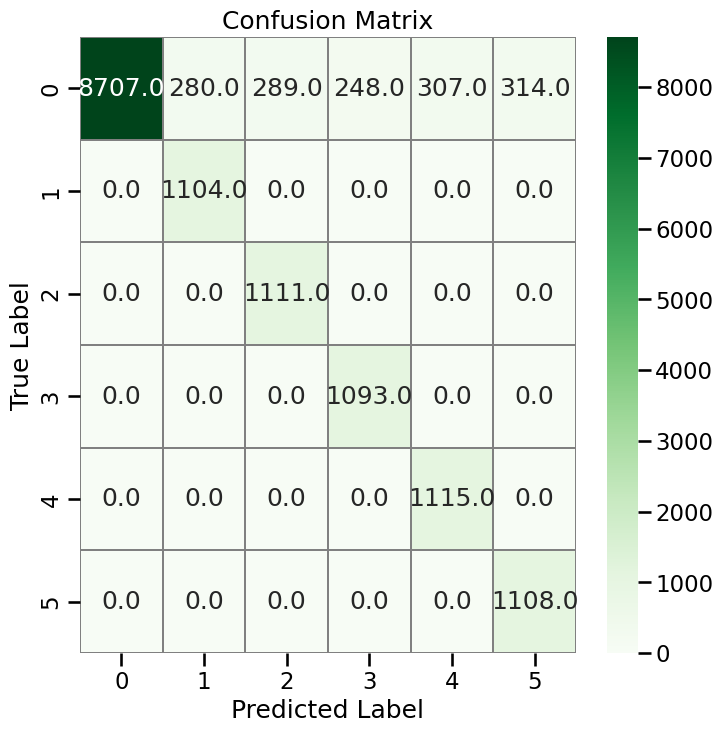

In [62]:
#confusion matrix
confusion_mtx = confusion_matrix(y_train, y_pred_h)

#plot of the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Prediction

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(y_pred_train, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_train, target_names=GESTURES))
print(classification_report(y_test, y_pred_test, target_names=GESTURES))

# Real-time inference

In [ ]:
import time
import serial
from IPython.display import clear_output

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];

def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [ ]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [ ]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

In [ ]:
TIMEOUT = 0.033
DEBUG = False

i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],

    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:

    # [Data reading]
    ts_start = time.time()

    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])

    except Exception as e:
        print(e)

    # [/Data Reading]

    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]

    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]

    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]

    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]

    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]

    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed

    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)

    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1

In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

In [ ]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [ ]:
print(classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()

    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()

i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:

    # [Data reading]
    s = ser.readline()
    ts_start = time.time()

    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])

    except Exception as e:
        print(e)

    # [/Data Reading]

    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]

    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]

    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]

    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]

    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]

    y_previous = y_postprocessed

    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)

    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1